In [13]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [16]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [17]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [18]:
magnetic.shape

(1533537, 11)

In [19]:
potential.head()

molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250

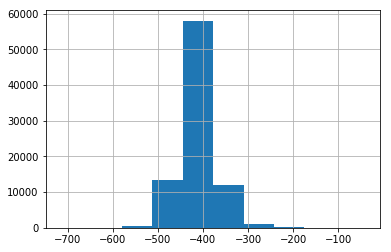

In [20]:
potential.potential_energy.hist()

In [21]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [22]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [23]:
y = train['scalar_coupling_constant']# - train['fc']

In [24]:
train = reduce_mem_usage(pd.read_csv('train_0.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('test_0.csv', index_col=0))

Mem. usage decreased to 746.32 Mb (75.0% reduction)
Mem. usage decreased to 391.87 Mb (75.6% reduction)


In [25]:
train_1 = reduce_mem_usage(pd.read_csv('train_1.csv', index_col=0))
test_1 = reduce_mem_usage(pd.read_csv('test_1.csv', index_col=0))

Mem. usage decreased to 315.41 Mb (73.1% reduction)
Mem. usage decreased to 169.65 Mb (73.1% reduction)


In [26]:
fs0 = [f for f in train_1.columns if f not in train.columns]
fs0

['c_x',
 'c_y',
 'c_z',
 'x_closest_0',
 'y_closest_0',
 'z_closest_0',
 'x_closest_1',
 'y_closest_1',
 'z_closest_1',
 'distance',
 'distance_center0',
 'distance_center1',
 'distance_c0',
 'distance_c1',
 'distance_f0',
 'distance_f1',
 'cos_c0_c1',
 'cos_f0_f1',
 'cos_center0_center1',
 'cos_c0',
 'cos_c1',
 'cos_f0',
 'cos_f1',
 'cos_center0',
 'cos_center1',
 'atom_n']

In [27]:
train_3 = reduce_mem_usage(pd.read_csv('input/train_giba.csv', index_col=None))
test_3 = reduce_mem_usage(pd.read_csv('input/test_giba.csv', index_col=None))

Mem. usage decreased to 910.68 Mb (71.8% reduction)
Mem. usage decreased to 501.79 Mb (71.2% reduction)


In [28]:
fs1 = [f for f in train_3.columns if f not in (train.columns.tolist() + fs0)]
fs1

['molecule_name',
 'id',
 'scalar_coupling_constant',
 'ID',
 'structure_atom_0',
 'structure_x_0',
 'structure_y_0',
 'structure_z_0',
 'structure_atom_1',
 'structure_x_1',
 'structure_y_1',
 'structure_z_1',
 'typei',
 'N1',
 'N2',
 'link0',
 'link1',
 'linkN',
 'dist_xyz',
 'inv_dist0',
 'inv_dist1',
 'inv_distP',
 'R0',
 'R1',
 'E0',
 'E1',
 'inv_dist0R',
 'inv_dist1R',
 'inv_distPR',
 'inv_dist0E',
 'inv_dist1E',
 'inv_distPE',
 'linkM0',
 'linkM1',
 'min_molecule_atom_0_dist_xyz',
 'mean_molecule_atom_0_dist_xyz',
 'max_molecule_atom_0_dist_xyz',
 'sd_molecule_atom_0_dist_xyz',
 'min_molecule_atom_1_dist_xyz',
 'mean_molecule_atom_1_dist_xyz',
 'max_molecule_atom_1_dist_xyz',
 'sd_molecule_atom_1_dist_xyz',
 'molecule_name.1',
 'atom_index_1.1',
 'coulomb_C.x',
 'coulomb_F.x',
 'coulomb_H.x',
 'coulomb_N.x',
 'coulomb_O.x',
 'yukawa_C.x',
 'yukawa_F.x',
 'yukawa_H.x',
 'yukawa_N.x',
 'yukawa_O.x',
 'coulomb_C.y',
 'coulomb_F.y',
 'coulomb_H.y',
 'coulomb_N.y',
 'coulomb_O.y',
 '

In [29]:
train = pd.concat([train, train_1[fs0], train_3[fs1]], axis=1)
test = pd.concat([test, test_1[fs0], test_3[fs1]], axis=1)


In [30]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [31]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [32]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [33]:
train_babel_feat = pd.read_csv('input/train_ob_charges.csv')
test_babel_feat = pd.read_csv('input/test_ob_charges.csv')


In [34]:
train_babel_feat.shape

(1533537, 15)

In [35]:
train_babel_feat['atom_index_0'] = train_babel_feat.atom_index
train_babel_feat['atom_index_1'] = train_babel_feat.atom_index

test_babel_feat['atom_index_0'] = test_babel_feat.atom_index
test_babel_feat['atom_index_1'] = test_babel_feat.atom_index


In [36]:
bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']

In [37]:
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])

bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [38]:

bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])


In [39]:
bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [40]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0               x_0  \
0             1             0  1JHC             1       0  0.00214958190918   
1             1             2  2JHH             1       0  0.00214958190918   
2             1             3  2JHH             1       0  0.00214958190918   
3             1             4  2JHH             1       0  0.00214958190918   
4             2             0  1JHC             2       0  1.01171875000000   

                 y_0                z_0        EN_x           rad_x  ...  NF  \
0 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
1 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
2 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
3 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
4  1.463867187500000  0.000276565551758  2.19921875  0.429931640625  ... NaN   

   NO        fc              sd           pso            dso  \
0 NaN  83.00000  0.254638671875  1.2587890625  0.27197265625   
1 NaN -11.03125  0.353027343750  2.8574218750 -3.43359375000   
2 NaN -11.03125  0.353027343750  2.8593750000 -3.43359375000   
3 NaN -11.03125  0.353027343750  2.8593750000 -3.43359375000   
4 NaN  83.00000  0.254638671875  1.2587890625  0.27197265625   

               eem_x            qtpie_x              eem_y            qtpie_y  
0  0.161131359327947  0.773439349698371 -0.644530825087479 -3.093806799641671  
1  0.161131359327947  0.773439349698371  0.161131811379221  0.773442481023162  
2  0.161131359327947  0.773439349698371  0.161133990721081  0.773463412039650  
3  0.161131359327947  0.773439349698371  0.161133663659230  0.773461556880489  
4  0.161131811379221  0.773442481023162 -0.644530825087479 -3.093806799641671  

[5 rows x 205 columns]

In [41]:
train['q_0'] = train['eem_x'] * train['eem_y'] / train['dist'] ** 2
test['q_0'] = test['eem_x'] * test['eem_y'] / test['dist'] ** 2

train['q_1'] = train['qtpie_x'] * train['qtpie_y'] / train['dist'] ** 2
test['q_1'] = test['qtpie_x'] * test['qtpie_y'] / test['dist'] ** 2

In [42]:
scaler.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'fc', 'sd',
       'pso', 'dso'],
      dtype='object')

In [43]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [44]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [45]:
train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [46]:
train_2 = reduce_mem_usage(pd.read_csv('input/train_2.csv', index_col=0))
test_2 = reduce_mem_usage(pd.read_csv('input/test_2.csv', index_col=0))

Mem. usage decreased to 524.20 Mb (78.0% reduction)
Mem. usage decreased to 281.96 Mb (78.0% reduction)


In [47]:
train_2.head()

id     molecule_name  atom_index_0  atom_index_1  type atom1 atom2  type0  \
0   0  dsgdb9nsd_000001             1             0  1JHC     H     C      0   
1   1  dsgdb9nsd_000001             1             2  2JHH     H     H      1   
2   2  dsgdb9nsd_000001             1             3  2JHH     H     H      1   
3   3  dsgdb9nsd_000001             1             4  2JHH     H     H      1   
4   4  dsgdb9nsd_000001             2             0  1JHC     H     C      0   

   type1  type2  ...  a1_nb_inring8  a1_nb_nb_h  a1_nb_nb_o  a1_nb_nb_c  \
0      0      0  ...              0           0           0           1   
1      0      0  ...              0           4           0           0   
2      0      0  ...              0           4           0           0   
3      0      0  ...              0           4           0           0   
4      0      0  ...              0           0           0           1   

   a1_nb_nb_n  a1_nb_nb_na        x_a1_nb    y_a1_nb            z_a1_nb  \
0           0            0 -0.52392578125  1.4375000  0.906250000000000   
1           0            0 -0.01269531250  1.0859375  0.008003234863281   
2           0            0 -0.01269531250  1.0859375  0.008003234863281   
3           0            0 -0.01269531250  1.0859375  0.008003234863281   
4           0            0 -0.52392578125  1.4375000  0.906250000000000   

   dist_to_type_mean  
0       0.9990234375  
1       1.0048828125  
2       1.0048828125  
3       1.0048828125  
4       0.9990234375  

[5 rows x 66 columns]

In [48]:
train_2.drop(labels=['atom_index_0', 'atom_index_1' ,'type' ,'atom1', 'atom2', 'id'], axis=1, inplace=True)
test_2.drop(labels=['atom_index_0', 'atom_index_1' ,'type' ,'atom1', 'atom2', 'id'], axis=1, inplace=True)

In [49]:
fs2 = [f for f in train_2.columns if f not in train.columns]
fs2

['type0',
 'type1',
 'type2',
 'type3',
 'x0',
 'y0',
 'z0',
 'x1',
 'y1',
 'z1',
 'a1_degree',
 'a1_hybridization',
 'a1_inring',
 'a1_inring3',
 'a1_inring4',
 'a1_inring5',
 'a1_inring6',
 'a1_inring7',
 'a1_inring8',
 'a1_nb_h',
 'a1_nb_o',
 'a1_nb_c',
 'a1_nb_n',
 'a1_nb_na',
 'a0_nb_degree',
 'a0_nb_hybridization',
 'a0_nb_inring',
 'a0_nb_inring3',
 'a0_nb_inring4',
 'a0_nb_inring5',
 'a0_nb_inring6',
 'a0_nb_inring7',
 'a0_nb_inring8',
 'a0_nb_nb_h',
 'a0_nb_nb_o',
 'a0_nb_nb_c',
 'a0_nb_nb_n',
 'a0_nb_nb_na',
 'x_a0_nb',
 'y_a0_nb',
 'z_a0_nb',
 'a1_nb_degree',
 'a1_nb_hybridization',
 'a1_nb_inring',
 'a1_nb_inring3',
 'a1_nb_inring4',
 'a1_nb_inring5',
 'a1_nb_inring6',
 'a1_nb_inring7',
 'a1_nb_inring8',
 'a1_nb_nb_h',
 'a1_nb_nb_o',
 'a1_nb_nb_c',
 'a1_nb_nb_n',
 'a1_nb_nb_na',
 'x_a1_nb',
 'y_a1_nb',
 'z_a1_nb',
 'dist_to_type_mean']

In [50]:
train = pd.concat([train, train_2[fs2]], axis=1)
test = pd.concat([test, test_2[fs2]], axis=1)


In [51]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [52]:
del train_1, train_2
del test_1, test_2

gc.collect()

184

In [53]:
feature_files = os.listdir('oofs/')

train_files = sorted(filter(lambda x: 'validation_' in x, feature_files))
test_files = sorted(filter(lambda x: 'test_' in x, feature_files))

list(test_files)


['test_catb_gpu_v0.1.0-0.csv',
 'test_catb_gpu_v0.1.0.csv',
 'test_lgbm_dso_v0.2.3.csv',
 'test_lgbm_fc_v0.2.3.csv',
 'test_lgbm_kp_v0.1.0.csv',
 'test_lgbm_pso_v0.2.3.csv',
 'test_lgbm_sd_v0.2.3.csv',
 'test_lgbm_v0.1.0.csv',
 'test_lgbm_v0.1.2.csv',
 'test_lgbm_v0.1.3.csv',
 'test_lgbm_v0.1.7.csv',
 'test_lgbm_v0.2.2.csv',
 'test_lgbm_v0.2.4.csv',
 'test_lgbm_v0.2.5.csv',
 'test_lgbm_v0.2.7.csv',
 'test_lgbm_v0.3.0.csv',
 'test_lgbm_v0.3.1.csv',
 'test_lgbm_v0.3.2.csv',
 'test_lgbm_v0.3.4.csv',
 'test_lgbm_v0.3.5.csv',
 'test_lgbm_v0.3.6-0.csv',
 'test_lgbm_v0.3.6.csv',
 'test_lgbm_v0.3.7.csv',
 'test_lgbm_v0.3.8.csv',
 'test_nn_kp_scalar_v0.1.0.csv',
 'test_nn_kp_scalar_v0.1.2.csv',
 'test_nn_kp_v0.1.0.csv',
 'test_nn_v0.1.0.csv',
 'test_nn_v0.1.1.csv',
 'test_nn_v0.1.4.csv',
 'test_nnx_v0.1.3.csv']

In [54]:
train_stacked = pd.concat([pd.read_csv('oofs/' + file, index_col=None, header=0) for file in train_files], axis=1)
test_stacked = pd.concat([pd.read_csv('oofs/' + file, index_col=None, header=0) for file in test_files], axis=1)


train_stacked.columns = ['y_' + str(i) for i, f in enumerate(train_stacked.columns)]
test_stacked.columns = ['y_' + str(i) for i, f in enumerate(test_stacked.columns)]



In [55]:
train = pd.concat([train, train_stacked], axis=1)
test = pd.concat([test, test_stacked], axis=1)


In [56]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [66]:
train.head()

y_0                 y_1                y_2  \
0 -46.589243279662249  11.524747963967116  0.348767927822330   
1  -1.366387089015916  -1.407124654288054 -3.251046519061219   
2  -1.320450107334182  -1.455234299311996 -3.266246590449261   
3  -1.434511860999919  -1.403651862405240 -3.544024371500463   
4 -45.463809831849289  11.263322054137461  0.294816182072726   

                  y_3                 y_4                y_5  \
0  81.473897040774204  96.319785433552738  0.924771228119631   
1 -11.512268553960949 -11.296541828485900  2.697988864454660   
2 -12.322086509367075 -11.008688335366751  2.852279216180953   
3 -10.301765686073127 -12.720297141034033  2.775404452018809   
4  83.857588491003412  85.491149729248235  1.113409329671451   

                 y_6                 y_7                 y_8  \
0  0.212282024320432  93.970553772752794  95.844338752811581   
1  0.388137887421502  -9.568248599122628 -12.401272030396795   
2  0.383918908464709  -9.568248599122628 -11.952590364255633   
3  0.358979617565695  -9.398554543458314 -10.384991375236419   
4  0.248186182872487  97.022791649911397  88.651194863156206   

                  y_9  ...               y_23                y_24  \
0  87.287719368171622  ...  1.812452508202724  95.048549730648389   
1 -11.397119150641430  ... -0.185925043456509 -11.589163089548938   
2 -11.185645995236420  ... -0.177334674107531 -11.133968153857463   
3 -11.418125747048926  ... -0.229670780491647 -11.194055309663836   
4  86.073150258098778  ...  1.809981424814868  86.577416462750222   

                  y_25                 y_26                y_27  \
0  103.258251944079646  112.917228698730483  82.727394104003906   
1  -11.107584216784216  -11.230779647827148  -9.030854225158693   
2  -10.989346685628341  -12.033445358276367  -9.451404571533203   
3   -9.619963984126805  -10.072475433349609 -10.395615577697754   
4   88.355711104643376   84.729064941406250  83.548324584960938   

                 y_28                y_29                 y_30  \
0  98.973091125488281  91.391456604003906  105.926689147949219   
1  -9.886816024780273 -10.757715225219727  -10.777632713317873   
2  -9.344213485717773 -11.066827774047852  -11.302467346191404   
3 -10.105822563171387 -11.060810089111328   -9.890068054199221   
4  99.920852661132798  86.487365722656250   93.019058227539062   

      molecule_name  type  
0  dsgdb9nsd_000001  1JHC  
1  dsgdb9nsd_000001  2JHH  
2  dsgdb9nsd_000001  2JHH  
3  dsgdb9nsd_000001  2JHH  
4  dsgdb9nsd_000001  1JHC  

[5 rows x 33 columns]

In [64]:
train = train_stacked
test = test_stacked

In [65]:

train['molecule_name'] = train_3.molecule_name
test['molecule_name'] = test_3.molecule_name


train['type'] = train_3.type
test['type'] = test_3.type


In [60]:
train.shape

(4658147, 303)

In [61]:
# for f in ['structure_atom_0', 'structure_atom_1', 'molecule_name.1']:
#     train[f] = train[f].astype('category')
#     test[f] = test[f].astype('category')

In [67]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [ ]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
gc.collect()    
for type_ in np.unique(train['type']):

    if type_ == '1JHC':
        a, b, c = 2 ** 9, -1, 0.03
    else:
        a, b, c = 2 ** 7, 15, 0.05
    
    params = {'num_leaves': a,
          'min_child_samples': 79,
          'objective': 'regression_l2',
          'max_depth': b,
          'learning_rate': c,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 666,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 3,
          'colsample_bytree': 0.9
         }
    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    all_pos = np.sum(y_.apply(int).value_counts().index.values > 0)
    
#     if all_pos:
#         y_ = np.log1p(y_)
    
    all_pos = False
    
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'pso', 'dso']]
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 3000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=50)
        if all_pos:
            oof[train_index[valid_idx]] = np.expm1(clf.predict(x_train.iloc[valid_idx], 
                                                               num_iteration=clf.best_iteration))

            predictions[test_index] += np.expm1(clf.predict(test_[features],
                                                            num_iteration=clf.best_iteration)) / n_split

        else:
            oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

            predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 50 rounds.


In [ ]:
predictions

In [68]:
predictions

array([ 18.09673089, 187.69001889,  11.69250259, ...,   1.6381075 ,
         5.6235259 , 118.0202762 ])

In [69]:
test.shape

(2505542, 31)

In [70]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [71]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [72]:
sub.shape

(2505542, 2)

In [73]:
len(predictions)

2505542

In [74]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-rs-lgbm-v0.2.0.csv", index=False)

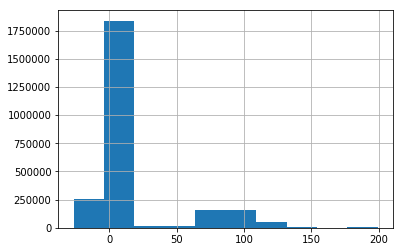

In [75]:
sub['scalar_coupling_constant'].hist()